In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error


# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import time
from pathlib import Path

In [2]:
#Importing Datasets
data = pd.read_csv('Datasets/cleaned_data.csv')
data = data.drop(['Unnamed: 0'], axis = 1)

## NLP on lyrics

In [3]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pradyumn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
%%time
data.lyrics = data.lyrics.apply(lambda x: preprocess(x)) # preprocessing the text data.

CPU times: user 1.15 s, sys: 19 ms, total: 1.16 s
Wall time: 1.2 s


In [5]:
data.lyrics[0]

'played fiddle irish band fell love english man kissed neck took hand said baby want dance met grafton street right outside bar shared cigarette brother played guitar asked mean gaelic ink arm said one friend songs want drink took jamie chaser jack fun got arthur table johnny riding shotgun chatted one drink bar put van jukebox got dance know played fiddle irish band fell love english man kissed neck took hand said baby want dance pretty little galway girl pretty little galway girl know beat darts beat pool kissed like nobody else room last orders called stood stool dancing c ilidh singing trad tunes never heard carrickfergus ever sang sweet capella bar using feet beat oh could voice playing repeat week packed room swear singing know played fiddle irish band fell love english man kissed neck took hand said baby want dance pretty little galway girl galway girl galway girl galway girl outstayed welcome closing time holding hand hand holding mine coats smell smoke whisky wine fill lungs c

In [6]:
# Split into train and test dataset.
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1284
TEST size: 321


In [7]:
data.lyrics[0:10]

0    played fiddle irish band fell love english man...
1    hey havana ooh na na ay half heart havana ooh ...
2    bed feels little bit bigger song radio sound f...
3    hey baby look way new addiction hey baby gotta...
4    remember broke first time saying enough like s...
5    hurting baby broken need loving loving need wi...
6    got condo manhattan baby girl hatnin ass invit...
7    queen since sixteen want things dream dreams a...
8    said let get town drive city away crowd though...
9    unwritten read mind undefined beginning pen ha...
Name: lyrics, dtype: object

## Word2vec


This neural network vectorizes the words so that each 'text' can be understood in a neural network. But, the main purpose of the 2 layer neural network is to convert text to a vector, where the vector can be read in to a future neural network AND has a relationship embeddings behind the vectorized values based on cosine similarity.

In [8]:
%%time
documents = [_text.split() for _text in df_train.lyrics] 

CPU times: user 18 ms, sys: 4.79 ms, total: 22.8 ms
Wall time: 23 ms


In [9]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size =300, # vector size 
                                            window=7, # distance between current and predicted word within a sentence
                                            min_count=10, # ignores words with total frequency less than the parameter
                                            workers=8) # threads
w2v_model.build_vocab(documents)
words = w2v_model.wv.index_to_key
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 2131


In [10]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=32)

CPU times: user 21.8 s, sys: 428 ms, total: 22.2 s
Wall time: 8.59 s


(4219836, 5659904)

In [11]:
w2v_model.wv.most_similar("love")

[('fails', 0.39134112000465393),
 ('soft', 0.3720150589942932),
 ('true', 0.36757105588912964),
 ('apart', 0.36659008264541626),
 ('hunk', 0.3522321581840515),
 ('needing', 0.3362979292869568),
 ('show', 0.3285921812057495),
 ('heart', 0.327623188495636),
 ('ordinary', 0.32733508944511414),
 ('fallin', 0.3108413517475128)]

## Tokenize Text & Create Embedding Layer.


In [12]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.lyrics)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 11486
CPU times: user 237 ms, sys: 9.24 ms, total: 246 ms
Wall time: 259 ms


In [13]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.lyrics), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.lyrics), maxlen=300)

CPU times: user 144 ms, sys: 8.43 ms, total: 153 ms
Wall time: 149 ms


In [14]:
print(len(x_train), len(x_test))

1284 321


In [15]:
x_train

array([[    0,     0,     0, ...,   217,  1109,  1880],
       [    0,     0,     0, ...,    34,   479,   280],
       [    0,     0,     0, ...,    61,   127,   352],
       ...,
       [    0,     0,     0, ...,  1958,   312,    85],
       [    0,     0,     0, ...,   540, 11484,   540],
       [    0,     0,     0, ...,     8,  3422,  6572]], dtype=int32)

In [16]:
# Creating an embedding layer that will act as an input layer for the neural network.
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)
# used in the future.
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

(11486, 300)


In [17]:
y_train = df_train['popularity'].values
y_train

array([0.7311828 , 0.68817204, 0.70967742, ..., 0.38709677, 0.7311828 ,
       0.29032258])

In [18]:
y_test = df_test['popularity'].values
y_test

array([0.79569892, 0.6344086 , 0.80645161, 0.        , 0.6344086 ,
       0.83870968, 0.58064516, 0.52688172, 0.56989247, 0.8172043 ,
       0.55913978, 0.07526882, 0.35483871, 0.37634409, 0.41935484,
       0.67741935, 0.90322581, 0.46236559, 0.8172043 , 0.78494624,
       0.75268817, 0.92473118, 0.47311828, 0.50537634, 0.75268817,
       0.62365591, 0.91397849, 0.5483871 , 0.49462366, 0.64516129,
       0.89247312, 0.66666667, 0.67741935, 0.70967742, 0.68817204,
       0.68817204, 0.03225806, 0.50537634, 0.84946237, 0.68817204,
       0.49462366, 0.83870968, 0.74193548, 0.65591398, 0.62365591,
       0.88172043, 0.61290323, 0.72043011, 0.67741935, 0.53763441,
       0.51612903, 0.78494624, 0.53763441, 0.61290323, 0.34408602,
       0.70967742, 0.56989247, 0.75268817, 0.7311828 , 0.27956989,
       0.13978495, 0.74193548, 0.07526882, 0.25806452, 0.77419355,
       0.49462366, 0.5483871 , 0.82795699, 0.70967742, 0.75268817,
       0.50537634, 0.90322581, 0.34408602, 0.79569892, 0.66666

In [19]:
y_train = np.reshape(y_train, (-1,1))  
y_test = np.reshape(y_test, (-1,1))
print("y_train",y_train.shape)
print("y_test",y_test.shape) 

y_train (1284, 1)
y_test (321, 1)


In [20]:
df_train.head(5)

,album_name,release_date,artist_name,explicit,song_name,lyrics,language,total_tracks,duration_ms,popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
705,Hozier (Expanded Edition),2014-09-19,hozier,False,Jackie and Wilson,tired trying see behind red eyes better versio...,en,0.157303,0.099640,0.731183,...,0.545455,0.866771,1.0,0.035325,0.059141,0.000008,0.079222,0.737667,0.195852,0.75
963,Biz's Baddest Beats: The Best of Biz Markie,1994-08-07,biz markie,False,Just a Friend,ever met girl tried date year make love wanted...,en,0.157303,0.116642,0.688172,...,0.000000,0.632595,1.0,0.415685,0.122573,0.000000,0.322973,0.840092,0.215968,0.75
599,Connection,2018-06-26,onerepublic,False,Connection,days waves get lost oceans seven billion swimm...,en,0.000000,0.015841,0.709677,...,0.454545,0.833220,1.0,0.046212,0.000854,0.000000,0.099109,0.617475,0.742328,0.75
411,The Fray,2009-02-02,the fray,False,You Found Me,found god corner first amistad west alone smok...,en,0.101124,0.120667,0.827957,...,0.727273,0.807764,0.0,0.040880,0.019100,0.000000,0.125190,0.383361,0.639656,0.75
710,Tom Petty & The Heartbreakers,1976-11-09,tom petty and the heartbreakers,False,American Girl,well american girl raised promises help thinki...,en,0.101124,0.090227,0.817204,...,0.181818,0.779674,1.0,0.023328,0.457609,0.000129,0.375136,0.777383,0.401515,0.75


## Creating the Model

In [28]:
callback = EarlyStopping(monitor='val_loss', patience=2)
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) # This can be BERT which may have better performance.   
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          3445800   
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,606,301
Trainable params: 160,501
Non-trainable params: 3,445,800
_________________________________________________________________


In [29]:
model.compile(loss='mse',
              optimizer="adam")

## Train

In [30]:
%%time
model.fit(x_train,
        y_train,
        epochs=8,
        validation_split=0.1,
        verbose=1,
         callbacks = callback)

Epoch 1/8
37/37 [==============================] - 28s 682ms/step - loss: 0.1455 - val_loss: 0.0797
Epoch 2/8
37/37 [==============================] - 27s 738ms/step - loss: 0.0754 - val_loss: 0.0603
Epoch 3/8
37/37 [==============================] - 31s 847ms/step - loss: 0.0602 - val_loss: 0.0542
Epoch 4/8
37/37 [==============================] - 30s 800ms/step - loss: 0.0511 - val_loss: 0.0477
Epoch 5/8
37/37 [==============================] - 34s 911ms/step - loss: 0.0455 - val_loss: 0.0475
Epoch 6/8
37/37 [==============================] - 33s 882ms/step - loss: 0.0416 - val_loss: 0.0541
Epoch 7/8
37/37 [==============================] - 28s 765ms/step - loss: 0.0391 - val_loss: 0.0469
Epoch 8/8
37/37 [==============================] - 28s 765ms/step - loss: 0.0380 - val_loss: 0.0537
CPU times: user 9min 35s, sys: 3min 18s, total: 12min 53s
Wall time: 3min 59s


## Evaluate

<AxesSubplot:>

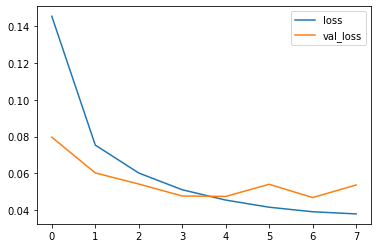

In [31]:
model_losses = pd.DataFrame(model.history.history)
model_losses.plot()

In [32]:
predictions = model.predict(x_test)
sample = pd.DataFrame(predictions,columns=['Predict'])
sample['Actual']=y_test
sample.head(10)

,Predict,Actual
0,0.752330,0.795699
1,0.709615,0.634409
2,0.612408,0.806452
3,0.729415,0.000000
4,0.681972,0.634409
5,0.763685,0.838710
6,0.713005,0.580645
7,0.560062,0.526882
8,0.589114,0.569892
9,0.773926,0.817204


In [33]:
mean_absolute_error(y_test,predictions)

0.19798959852506842

In [34]:
np.sqrt(mean_squared_error(y_test,predictions))

0.264932064041619